### Imports

In [1]:
from torch import nn
from torch import optim
from torch.functional import F
from torchvision import transforms
from torchsummary import summary
from torch.utils.data import RandomSampler
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt
import random
import torch
import torchvision

### Constants and definitions

In [2]:
%matplotlib inline

# model training parameters
BATCH_SIZE = 256
COMPRESSED_DIMS = 2
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS = 25
LEARNING_RATE = 1e-3

### Load dataset

Download (if necessary) and load MNIST dataset:

In [3]:
# load MNIST training subset and normalize
MNIST_train = torchvision.datasets.MNIST('../data/', 
                                         train = True, 
                                         download = True, 
                                         transform = transforms.Compose([transforms.ToTensor(),
                                                                         transforms.Normalize((0.1307,), (0.3081,))]))
# load MNIST test subset and normalize
MNIST_test = torchvision.datasets.MNIST('../data/', 
                                        train = False, 
                                        download = True,
                                        transform=transforms.Compose([transforms.ToTensor(),
                                                                      transforms.Normalize((0.1307,), (0.3081,))]))

Training set:

In [4]:
MNIST_train

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

Test set:

In [5]:
MNIST_test

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../data/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

### Create data loaders

Training set dataloader (Pytorch convenience):

In [6]:
train_loader = torch.utils.data.DataLoader(MNIST_train, batch_size = BATCH_SIZE, shuffle = True)

Test set dataloader (no shuffling to save clocks, batch size twice as large because we don't need to store gradients on inference time):

In [7]:
test_loader = torch.utils.data.DataLoader(MNIST_test, batch_size = 2 * BATCH_SIZE, shuffle = False)

### Encoder network

Define encoder model:

In [8]:
class MNIST_Encoder(nn.Module):
    def __init__(self):
        super(MNIST_Encoder, self).__init__()
        self.encode = nn.Sequential(
                        nn.Flatten(),
                        nn.Linear(784, 512),
                        nn.ReLU(),
                        nn.Linear(512, 256),
                        nn.ReLU(),
                        nn.Linear(256, 128),
                        nn.ReLU(),
                        nn.Linear(128, 64),
                        nn.ReLU(),
                        nn.Linear(64, 32),
                        nn.ReLU(),
                        nn.Linear(32, COMPRESSED_DIMS))
                        

    def forward(self, x):
        return self.encode(x)

### Decoder network

Define decoder model:

In [9]:
class MNIST_Decoder(nn.Module):
    def __init__(self):
        super(MNIST_Decoder, self).__init__()
        self.decode = nn.Sequential(
                        nn.Linear(COMPRESSED_DIMS, 32),
                        nn.ReLU(),
                        nn.Linear(32, 64),
                        nn.ReLU(),
                        nn.Linear(64, 128),
                        nn.ReLU(),
                        nn.Linear(128, 256),
                        nn.ReLU(),
                        nn.Linear(256, 512),
                        nn.ReLU(),
                        nn.Linear(512, 784),
                        nn.ReLU(),
                        nn.Sigmoid())
        
    def forward(self, x):
        x = self.decode(x)        
        return x

### Autoencoder

Combine Encoder and Decoder in a single network, autoencoder:

In [10]:
class MNIST_Autoencoder(nn.Module):
    def __init__(self):
        super(MNIST_Autoencoder, self).__init__()
        self.encode = MNIST_Encoder()
        self.decode = MNIST_Decoder()
        
    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        
        return x

### Training loop

Create model:

In [11]:
autoencoder = MNIST_Autoencoder()
autoencoder = autoencoder.to(DEVICE)

In [12]:
summary(autoencoder, (1, 784))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
              ReLU-3                  [-1, 512]               0
            Linear-4                  [-1, 256]         131,328
              ReLU-5                  [-1, 256]               0
            Linear-6                  [-1, 128]          32,896
              ReLU-7                  [-1, 128]               0
            Linear-8                   [-1, 64]           8,256
              ReLU-9                   [-1, 64]               0
           Linear-10                   [-1, 32]           2,080
             ReLU-11                   [-1, 32]               0
           Linear-12                    [-1, 2]              66
    MNIST_Encoder-13                    [-1, 2]               0
           Linear-14                   

Define optimizer:

In [13]:
optimizer = optim.Adam(autoencoder.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

Training loop:

In [14]:
def fit(epochs, model, loss, optimizer, data):
    
    # initialize info dict
    info = {
        'epoch': [],
        'loss': []
    }
        
    # for each epoch
    for epoch in range(epochs):
    
        # set model in training mode
        model.train()
        
        # iterate through the dataset
        for x, _ in tqdm(data):
            
            # send data to GPU
            x = x.to(DEVICE)
            
            # infer and compute loss
            y_hat = model(x)
            loss_value = loss(y_hat, x.reshape(x.size()[0], -1))
                        
            # update weights
            loss_value.backward()
            optimizer.step()
            optimizer.zero_grad()

        # set model in inference mode
        model.eval()
        
        # without computing gradients
        with torch.no_grad():
            
            # compute validation loss
            validation_loss = 0
            for batch, _ in test_loader:
                x_val = batch.reshape(batch.size()[0], -1)
                x_val = x_val.to(DEVICE)
                y_val = model(batch.to(DEVICE))
                validation_loss += loss(y_val, x_val)            
        
        # update info
        validation_loss = validation_loss.item() / len(MNIST_train)
        info['epoch'].append(epoch + 1)
        info['loss'].append(validation_loss)
        
        # log
        print(f'End of epoch: {epoch + 1}\nValidation loss: {validation_loss}\n\n')
            
    # return training info
    return info

In [15]:
info = fit(EPOCHS, autoencoder, nn.MSELoss(), optimizer, train_loader)


End of epoch: 1
Validation loss: 0.00039339780807495117





End of epoch: 2
Validation loss: 0.00039031702677408853





End of epoch: 3
Validation loss: 0.00038948345184326174





End of epoch: 4
Validation loss: 0.0003886837323506673





End of epoch: 5
Validation loss: 0.0003883017857869466





End of epoch: 6
Validation loss: 0.0003877323786417643





End of epoch: 7
Validation loss: 0.0003868963877360026





End of epoch: 8
Validation loss: 0.0003860926628112793





End of epoch: 9
Validation loss: 0.0003853219032287598





End of epoch: 10
Validation loss: 0.0003848883946736654





End of epoch: 11
Validation loss: 0.00038450870513916015





End of epoch: 12
Validation loss: 0.0003842198689778646





End of epoch: 13
Validation loss: 0.0003835809071858724





End of epoch: 14
Validation loss: 0.0003833809534708659





End of epoch: 15
Validation loss: 0.000383190123240153





End of epoch: 16
Validation loss: 0.00038269306818644204





End of epoch: 17
Validation loss: 0.0003822924296061198





End of epoch: 18
Validation loss: 0.00038171148300170896





End of epoch: 19
Validation loss: 0.0003813407262166341





End of epoch: 20
Validation loss: 0.0003805053393046061





End of epoch: 21
Validation loss: 0.0003800994873046875





End of epoch: 22
Validation loss: 0.0003800569852193197





End of epoch: 23
Validation loss: 0.00037947848637898764





End of epoch: 24
Validation loss: 0.00037876590092976887





End of epoch: 25
Validation loss: 0.00037872133255004885




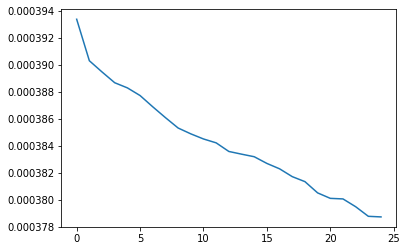

In [16]:
plt.plot(list(range(len(info['epoch']))), info['loss'])

### Results

##### - Image reconstruction

In [17]:
# bring model back to CPU (faster for stochastic evaluation)
autoencoder = autoencoder.to('cpu')

# put model on inference mode
autoencoder.eval();

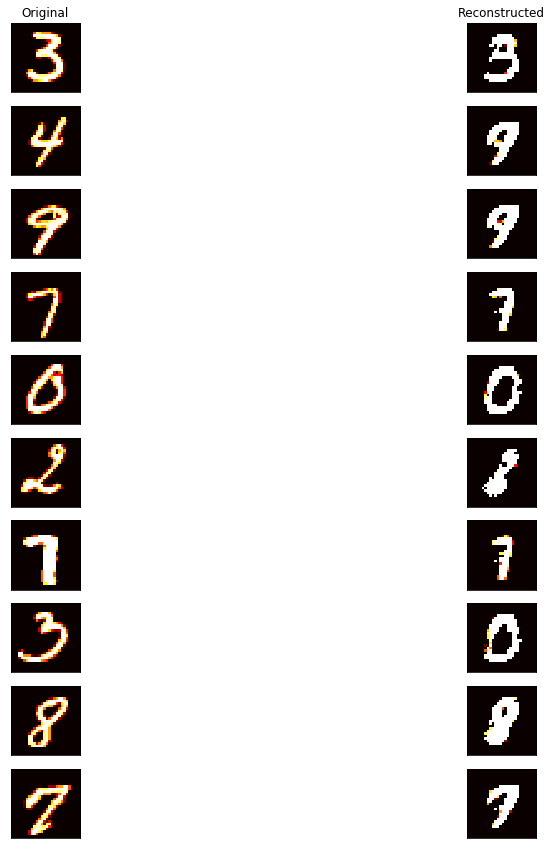

In [18]:
# create empty image containers
originals = []
generated = []

# without computing gradients
with torch.no_grad():
    
    # select and reconstruct 10 digits
    for _ in range(10):
        sample = random.randint(0, len(MNIST_test))
        original = MNIST_test[sample][0]
        x = original.unsqueeze(0)
        y = autoencoder(x)
        originals.append(original.squeeze())
        generated.append(y.squeeze().reshape(28, 28))

# plot
f, axes = plt.subplots(10, 
                       2,
                       figsize=(15,15),
                       sharex=True, 
                       sharey=True,
                       subplot_kw=dict(aspect='equal'))

axes[0][0].set_title('Original')
axes[0][1].set_title('Reconstructed')
for i in range(10):
    axes[i][0].imshow(originals[i], cmap='hot')
    axes[i][0].set_xticks([])
    axes[i][0].set_yticks([])
    axes[i][1].imshow(generated[i], cmap='hot')
    axes[i][1].set_xticks([])
    axes[i][1].set_yticks([])

##### - Generated distribution

In [19]:
# get encoder part of the autoencoder
encoder = autoencoder.encode
encoder.eval();

In [20]:
# get random batch from test set
test_images, test_labels = next(iter(test_loader))

# setup empty encodings
encodings = {i : [] for i in range(10)}

# without computing gradients
with torch.no_grad():
    
    # for each digit in the dataset
    for digit in range(10):
        
        # encode and store samples
        images = test_images[test_labels == digit]
        encoded = encoder(images)
        encodings[digit] = [value.numpy() for value in encoded]

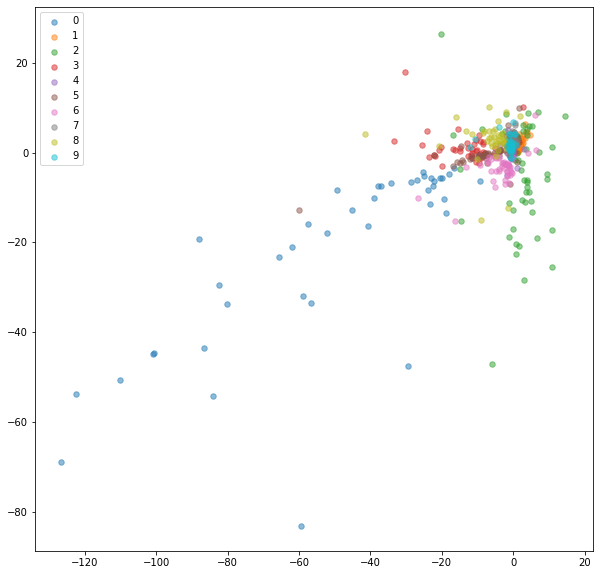

In [21]:
# plot distribution
fig = plt.figure(figsize=(10, 10))
axis = fig.add_subplot(1, 1, 1)
for digit in encodings.keys():
    xs = [x[0] for x in encodings[digit]]
    ys = [x[1] for x in encodings[digit]]
    axis.scatter(xs, ys, alpha=0.5, s=30, label=str(digit))
        
plt.legend(loc=2)
plt.show()

##### - Generate your own digits

In [22]:
# get decoder part of the autoencoder
decoder = autoencoder.decode
decoder = decoder.to('cpu')
decoder.eval();

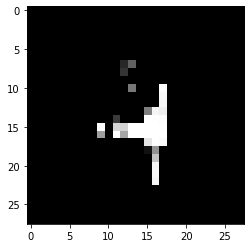

In [23]:
# enter your encoded representation here
encoded = torch.tensor([[0., 0.]])

# without computing gradients
with torch.no_grad():
    
    # reconstruct image from representation
    x = decoder(encoded)
    
# display generated image
plt.imshow(x.view(28, 28).numpy(), cmap='gray')